<a href="https://colab.research.google.com/github/dataML007/NLP-Project/blob/master/Final_Project_Running_Code_0422.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import re

import json
import math
import glob
import time

import string
import random
import pickle

import functools
import collections

from tqdm import tqdm
from PIL import Image
import seaborn as sns

from nltk import PorterStemmer
import torch.nn.functional as F


# from pyecharts.charts import Graph
# from pyecharts import options as opts
from keras.preprocessing import sequence
from scipy.spatial.distance import cdist
from nltk.corpus import stopwords 
from nltk.corpus import wordnet
from IPython.core.display import display, HTML

from nltk.tokenize import word_tokenize, sent_tokenize
from torch.utils.data import Dataset,TensorDataset,DataLoader

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem import LancasterStemmer, PorterStemmer, SnowballStemmer, WordNetLemmatizer

import pandas as pd


import plotly
import plotly.offline as pyo
import plotly.graph_objects as go

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


import re
import glob
import json
import scipy.sparse
import pickle

from sklearn.feature_extraction.text import CountVectorizer


# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import matutils, models


# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
from IPython.display import IFrame
%matplotlib inline

# Enable logging for gensim - optional
import logging

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 12.1MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=b33d21e26602ca4613513438aa90e2bfd1f3bc52c6a7d1cbab5af59bd778ada5
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=ffb514ff536d1209a06e5d458b66327c86a581a8e0635a607462b5267d335d22
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [5]:
# check version 
import sys #access to system parameters https://docs.python.org/3/library/sys.html
print("Python version: {}". format(sys.version))

import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib #collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np #foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp #collection of functions for scientific computing and advance mathematics
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn #collection of machine learning algorithms
print("scikit-learn version: {}". format(sklearn.__version__))

import tensorflow as tf
print("tensorflow version: {}". format(tf.__version__))

import torch #collection of machine learning algorithms
print("torch version: {}". format(torch.__version__))


# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
print('-'*71)


from subprocess import check_output

Python version: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
pandas version: 1.0.3
matplotlib version: 3.2.1
NumPy version: 1.18.2
SciPy version: 1.4.1
IPython version: 5.5.0
scikit-learn version: 0.22.2.post1
tensorflow version: 2.2.0-rc3
torch version: 1.4.0
-----------------------------------------------------------------------


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
drive_path = 'drive/My Drive/Colab Notebooks/NLP_Indiana/Input/'

In [8]:
import pandas as pd
## load the meta data from the CSV file 
df = pd.read_csv(drive_path + 'Metadata.csv',header = 0,  # you can specify the header where it is from
                 usecols=['title','abstract','authors','doi','publish_time','source_x'],   # select use columns
                 dtype={
                        'Microsoft Academic Paper ID': str,
                        'pubmed_id': str,
                        'doi': str,                       
                       },
                 low_memory=False)

print (f'The shape of the input data:\n{df.shape[0]} articles, every article has {df.shape[1]} features')
print(df.info())
print(f'None data:\n{df.isnull().sum()}')
df.sample(3)

# before 2020, maybe publication about COVID-2019 is not out.
df_2020 = df.query("'2020' in publish_time")

# I think Confidence Interval (CI) is used epidemiological evaluation
df_2020_ci = df_2020.loc[df_2020["abstract"].str.contains("CI").fillna(False), :]

print(df_2020_ci.shape)
df_2020_ci.head()

The shape of the input data:
51078 articles, every article has 6 features
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51078 entries, 0 to 51077
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   source_x      51078 non-null  object
 1   title         50920 non-null  object
 2   doi           47741 non-null  object
 3   abstract      42352 non-null  object
 4   publish_time  51070 non-null  object
 5   authors       48891 non-null  object
dtypes: object(6)
memory usage: 2.3+ MB
None
None data:
source_x           0
title            158
doi             3337
abstract        8726
publish_time       8
authors         2187
dtype: int64
(17, 6)


,source_x,title,doi,abstract,publish_time,authors
26194,CZI,Backcalculating the Incidence of Infection wit...,10.3390/jcm9030657,To understand the time-dependent risk of infec...,2020,"Nishiura, Hiroshi"
26218,CZI,Analysis of factors associated with disease ou...,10.1097/cm9.0000000000000775,"BACKGROUND: Since early December 2019, the 201...",2020,"Liu, Wei; Tao, Zhao-Wu; Lei, Wang; Ming-Li, Yu..."
26446,WHO,[Analysis of myocardial injury in patients wit...,10.3760/cma.j.cn112148-20200225-00123,Objective: To evaluate the cardiovascular dama...,2020,"Chen, C.; Yan, J. T.; Zhou, N.; Zhao, J. P.; W..."
26470,WHO,Study on assessing early epidemiological param...,10.3760/cma.j.cn112338-20200205-00069,Objective: To study the early dynamics of the ...,2020,"Song, Q. Q.; Zhao, H.; Fang, L. Q.; Liu, W.; Z..."
26472,WHO,Estimating the basic reproduction number of CO...,10.3760/cma.j.cn112338-20200210-00086,Objective: The number of confirmed and suspect...,2020,"Wang, Y.; You, X. Y.; Wang, Y. J.; Peng, L. P...."


In [9]:
%%time
train_data = pd.read_csv(drive_path + 'train.csv')

CPU times: user 9.43 s, sys: 2.07 s, total: 11.5 s
Wall time: 17.7 s


In [0]:
CountryList = ["united states",
"afghanistan",
"albania",
"algeria",
"american samoa",
"andorra",
"angola",
"anguilla",
"antarctica",
"antigua and barbuda",
"argentina",
"armenia",
"aruba",
"australia",
"austria",
"azerbaijan",
"bahamas",
"bahrain",
"bangladesh",
"barbados",
"belarus",
"belgium",
"belize",
"benin",
"bermuda",
"bhutan",
"bolivia",
"bosnia and herzegowina",
"botswana",
"bouvet island",
"brazil",
"brunei darussalam",
"bulgaria",
"burkina faso",
"burundi",
"cambodia",
"cameroon",
"canada",
"cape verde",
"cayman islands",
"central african rep",
"chad",
"chile",
"china",
"christmas island",
"cocos islands",
"colombia",
"comoros",
"congo",
"cook islands",
"costa rica",
"cote d`ivoire",
"croatia",
"cuba",
"cyprus",
"czech republic",
"denmark",
"djibouti",
"dominica",
"dominican republic",
"east timor",
"ecuador",
"egypt",
"el salvador",
"equatorial guinea",
"eritrea",
"estonia",
"ethiopia",
"falkland islands (malvinas",
"faroe islands",
"fiji",
"finland",
"france",
"french guiana",
"french polynesia",
"french s. territories",
"gabon",
"gambia",
"georgia",
"germany",
"ghana",
"gibraltar",
"greece",
"greenland",
"grenada",
"guadeloupe",
"guam",
"guatemala",
"guinea",
"guinea-bissau",
"guyana",
"haiti",
"honduras",
"hong kong",
"hungary",
"iceland",
"india",
"indonesia",
"iran",
"iraq",
"ireland",
"israel",
"italy",
"jamaica",
"japan",
"jordan",
"kazakhstan",
"kenya",
"kiribati",
"korea (north",
"korea (south",
"kuwait",
"kyrgyzstan",
"laos",
"latvia",
"lebanon",
"lesotho",
"liberia",
"libya",
"liechtenstein",
"lithuania",
"luxembourg",
"macau",
"macedonia",
"madagascar",
"malawi",
"malaysia",
"maldives",
"mali",
"malta",
"marshall islands",
"martinique",
"mauritania",
"mauritius",
"mayotte",
"mexico",
"micronesia",
"moldova",
"monaco",
"mongolia",
"montserrat",
"morocco",
"mozambique",
"myanmar",
"namibia",
"nauru",
"nepal",
"netherlands",
"netherlands antilles",
"new caledonia",
"new zealand",
"nicaragua",
"niger",
"nigeria",
"niue",
"norfolk island",
"northern mariana islands",
"norway",
"oman",
"pakistan",
"palau",
"panama",
"papua new guinea",
"paraguay",
"peru",
"philippines",
"pitcairn",
"poland",
"portugal",
"puerto rico",
"qatar",
"reunion",
"romania",
"russian federation",
"rwanda",
"saint kitts and nevis",
"saint lucia",
"st vincent/grenadines",
"samoa",
"san marino",
"sao tome",
"saudi arabia",
"senegal",
"seychelles",
"sierra leone",
"singapore",
"slovakia",
"slovenia",
"solomon islands",
"somalia",
"south africa",
"spain",
"sri lanka",
"st. helena",
"st.pierre",
"sudan",
"suriname",
"swaziland",
"sweden",
"switzerland",
"syrian arab republic",
"taiwan",
"tajikistan",
"tanzania",
"thailand",
"togo",
"tokelau",
"tonga",
"trinidad and tobago",
"tunisia",
"turkey",
"turkmenistan",
"tuvalu",
"uganda",
"ukraine",
"united arab emirates",
"united kingdom",
"uruguay",
"uzbekistan",
"vanuatu",
"vatican city state",
"venezuela",
"viet nam",
"virgin islands (british",
"virgin islands (u.s.",
"western sahara",
"yemen",
"yugoslavia",
"zaire",
"zambia",
"zimbabwe",
"u.s",
"u.k.",
"u.s.",
"u.k",
"usa",
"uk"]



In [11]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

new = []
for idx,row in train_data.iterrows():
  #new = row['full_text'].split()
  for i in row['full_text'].split():
    if i.isalnum():
      if i.casefold() not in stop_words:
        if i.casefold() in CountryList:
          new.append(i.lower())



         
#alphanumeric = [character for character in a_string if character.isalnum()]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def CountFrequency(my_list): 
      
    # Creating an empty dictionary  
    freq = {} 
    for items in my_list: 
        freq[items] = my_list.count(items.casefold()) 
    return(freq)
    
      
      
    #for key, value in freq.items(): 
     #   print ("% s : % d"%(key, value)) 
# Driver function 
if __name__ == "__main__":  
    #my_list =[1, 1, 1, 5, 5, 3, 1, 3, 3, 1, 4, 4, 4, 2, 2, 2, 2] 
    freqNew = CountFrequency(new) 

In [0]:
research_country = pd.DataFrame(freqNew.items(), columns=['Country', 'Value'])

In [14]:
research_country.reset_index(drop=True)

,Country,Value
0,china,25756
1,ethiopia,338
2,qatar,505
3,thailand,2309
4,myanmar,251
...,...,...
166,kiribati,48
167,montserrat,10
168,tuvalu,4
169,nauru,4


In [15]:
research_country.sort_values("Value", ascending=False)

,Country,Value
0,china,25756
41,guinea,7547
40,usa,6138
11,uk,6034
8,japan,5729
...,...,...
168,tuvalu,4
169,nauru,4
165,pitcairn,2
170,tonga,2


In [0]:
research_country.loc[research_country['Country']=='uk','Country'] = 'United Kingdom of Great Britain and Northern Ireland'
research_country.loc[research_country['Country']=='usa','Country'] = 'United States of America'

In [18]:
pip install iso3166

In [0]:
for c in countries:
  print(c)

Country(name='Afghanistan', alpha2='AF', alpha3='AFG', numeric='004', apolitical_name='Afghanistan')
Country(name='Åland Islands', alpha2='AX', alpha3='ALA', numeric='248', apolitical_name='Åland Islands')
Country(name='Albania', alpha2='AL', alpha3='ALB', numeric='008', apolitical_name='Albania')
Country(name='Algeria', alpha2='DZ', alpha3='DZA', numeric='012', apolitical_name='Algeria')
Country(name='American Samoa', alpha2='AS', alpha3='ASM', numeric='016', apolitical_name='American Samoa')
Country(name='Andorra', alpha2='AD', alpha3='AND', numeric='020', apolitical_name='Andorra')
Country(name='Angola', alpha2='AO', alpha3='AGO', numeric='024', apolitical_name='Angola')
Country(name='Anguilla', alpha2='AI', alpha3='AIA', numeric='660', apolitical_name='Anguilla')
Country(name='Antarctica', alpha2='AQ', alpha3='ATA', numeric='010', apolitical_name='Antarctica')
Country(name='Antigua and Barbuda', alpha2='AG', alpha3='ATG', numeric='028', apolitical_name='Antigua and Barbuda')
Countr

In [0]:
from iso3166 import countries
new = []
for i,j in research_country.iterrows():
  counter = 0
  for c in countries:
    if j['Country'].lower() == c.name.lower():
      #print(j['Country'].lower(), c.name.lower(), "Found")
      new.append(c.alpha3)
      counter = counter+1    
  if(counter == 0):
    new.append('No ISO')

    
research_country['ISO_Compatible'] = pd.DataFrame(new)

In [20]:
research_country[research_country['ISO_Compatible'] == 'USA']

,Country,Value,ISO_Compatible
40,United States of America,6138,USA


In [21]:
pip install plotly

In [0]:
pip install plotly chart-studio

     |████████████████████████████████| 71kB 1.7MB/s 


In [0]:
import chart_studio.plotly
import plotly.tools as tls

In [22]:
pip install geopandas

     |████████████████████████████████| 931kB 2.8MB/s 
     |████████████████████████████████| 10.4MB 49.6MB/s 
     |████████████████████████████████| 14.7MB 212kB/s 


In [23]:
pip install shapely

In [0]:
import matplotlib.pyplot as plt
import geopandas as gpd

In [25]:
pip install pyshp

     |████████████████████████████████| 225kB 2.8MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-cp36-none-any.whl size=32609 sha256=cc8c232c303d5aa85c9e0d475058214070e1316fa09ee16cc1a59bc535eab6ed
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp


In [0]:
import plotly.figure_factory as ff

In [0]:
scope = ['world']
values = research_country['Value'].tolist()
country = research_country['Country'].tolist()

In [0]:
data = [dict(type='choropleth',autocolorscale = False, locations = research_country['Country'],z=research_country['Value'],locationmode = 'ISO-3',text=research_country['Value'],colorscale='custom-colorscale',colorbar=dict(title="test"))]



In [30]:
import plotly.express as px
fig = px.choropleth(research_country, locations="ISO_Compatible",
                    color="Value", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Reds)
fig.show()

In [0]:
'''import plotly.express as px

df = px.data.gapminder().query("year==2007")
fig = px.choropleth(df, locations="iso_alpha",
                    color="lifeExp", # lifeExp is a column of gapminder
                    hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()
'''

In [0]:
df.head()

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
11,Afghanistan,Asia,2007,43.828,31889923,974.580338,AFG,4
23,Albania,Europe,2007,76.423,3600523,5937.029526,ALB,8
35,Algeria,Africa,2007,72.301,33333216,6223.367465,DZA,12
47,Angola,Africa,2007,42.731,12420476,4797.231267,AGO,24
59,Argentina,Americas,2007,75.320,40301927,12779.379640,ARG,32


In [0]:
include_terms = ['sars-cov-2', 'covid-19', '2019-ncov', 'ncov-2019', 'betacoronavirus', 'pandemic', 'wuhan', 'virulence', 
                 'incidence', 'prevalence', 'mortality', 'self-resolve', 'immunity', 'community', 'spread' 'olfactory', 
                 'dysfunction', 'osmia', 'respiratory', 'pneumonia']

In [32]:
train_data.head()

,Unnamed: 0,paper_id,abstract,full_text
0,0,b915b88096b8bfd15199b71087479466308bd5ce,Many of the proteins produced by SARS-CoV-2 ha...,Severe acute respiratory syndrome coronavirus ...
1,1,ba1c4c0de19352d0b9ed7db6199803b621f0a8f2,Objective: To investigate psychological and be...,"In December 2019, coronavirus disease 2019 (CO..."
2,2,b9dbb79c9e06164c3b7fefce67c11c5d6caf1fcd,"Viruses evolve extremely quickly, so reliable ...",Within a globally interconnected and densely p...
3,3,ba3efcd6b74e55327fd7db470d824fc18943f30e,Global airline networks play a key role in the...,results indicate multiple countries (many with...
4,4,ba92c589f077b55e9cd13264d619c2ffe9d3ce7a,This paper focuses on the formulation of a det...,"On 31 December 2019, China notified an outbrea..."


In [33]:
# get only the abstracts from the dataframe

abstracts = dict(Abstract = [], Full_text = [])

for ind, row in train_data.iterrows():
    if pd.notna(row['abstract']) and pd.notna(row['full_text']):
        short = row['abstract']
        #print(short)
        t = row['full_text']
        #print(t)
        abstracts['Abstract'].append(t)
        abstracts['Full_text'].append(short)
        

#display abstracts as a plotly table
f_abs = go.Figure(data=go.Table(columnwidth = [150,350],
                  header = dict(values = ['Abstract', 'Full_text']),
                  cells= dict(values = [abstracts['Abstract'][0:5], abstracts['Full_text'][0:5]],
                             height = 20,
                             font = dict(size = 12),
                             align='left')
                            )
                 )
f_abs.show()


In [0]:
def lower(data):
    data = data.lower()
    return data


def remove_punctuation(data):
    symbols = "!\"#$%&()*+./:;<=>?@[\]^_`{|}~\n"
    for i in symbols:
        data = data.replace(i, " ")
    #replace the comma seperately
    data = data.replace(',', ' ')
    return data

def remove_apostraphe(data):
    data = data.replace("'", "")
    return data

def remove_numbers(data):
    nums = "0123456789"
    for i in nums:
        data = data.replace(i, "")
        return data

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text


    

In [35]:
%%time
nltk.download('punkt')
#Clean and Create TFIDF Matrix
# clean and replace with cleaned words
tf_dict = {}
idf_count = {}
for i, ab in train_data['abstract'].items():
    if pd.notna(ab):
        sent_dict = {}
        working = ab
        working = lower(working)
        working = remove_stop_words(working)
        working = remove_punctuation(working)
        working = remove_numbers(working)
        working = remove_apostraphe(working)
        working = remove_stop_words(working)
        tokens = working.split(' ')
    
        for word in tokens:
            for inc in include_terms:
                if inc in word:
                    if word in sent_dict.keys():
                        sent_dict[word] = sent_dict[word]+1
                    else:
                        sent_dict[word] = 1
                        if word in idf_count.keys():
                            idf_count[word] = idf_count[word]+1
                        else:
                            idf_count[word] = 1
        tf_dict[i] = sent_dict

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
CPU times: user 1min 39s, sys: 905 ms, total: 1min 40s
Wall time: 1min 40s


In [36]:
# calculate the tf-idf matrix
index = list(tf_dict.keys())
columns = list(idf_count.keys())
print("There were {} keywords generated from the Included Terms list".format(len(columns)))

#create an empty array for the tf-idf matrix
data = np.zeros((len(index), len(columns)))

#populate the tf-idf matrix
for i, doc in enumerate(index):
    for j, word in enumerate(columns):
        if word in tf_dict[doc]:
            if idf_count[word] !=1:
                data[i][j] = tf_dict[doc][word] * np.log(len(index)/idf_count[word])
            else:
                data[i][j] = np.nan
        else:
            data[i][j] = np.nan
            
#turn the tf_idf matrix into a dataframe
df_tfidf = pd.DataFrame(data, index = index, columns = columns)

#display results (head) as a plotly table
l = 15
w = 7
head = columns[0:w]
ind = index[0:l]
subset = data[0:l, 0:w]

f_tfidf = go.Figure(data=go.Table(
                  header = dict(values = head),
                  cells= dict(values = subset.T,
                             height = 20,
                             font = dict(size = 12),
                             align='left')
                            )
                 )
f_tfidf.show()

There were 274 keywords generated from the Included Terms list


In [42]:
cs = df_tfidf['community-acquired']
top_cs = cs.sort_values(ascending=False)[0:10]
final_cs = train_data['abstract'].iloc[top_cs.index].tolist()
final_cs_title = train_data['full_text'].iloc[top_cs.index].tolist()
final_cs_abstra = []
for abstra in final_cs:
    short = abstra[0:250]
    final_cs_abstra.append(short)
    
#plot in plotly
f_cs = go.Figure(data=go.Table(columnwidth = [150,350],
                  header = dict(values = ['Title', 'Abstracts For Community Acquired']),
                  cells= dict(values = [final_cs_title, final_cs_abstra],
                             height = 20,
                             font = dict(size = 12),
                             align='left')
                            )
                 )
f_cs.show()

**bold text**

In [44]:
 %%time
 import nltk
 #ingest body text for articles 
#df_covid = pd.read_csv('/kaggle/input/input/full_articlesLDA.csv') # Articles combined. 
#text = df_covid.drop(["paper_id","doi","title_abstract_body","Unnamed: 0", "abstract", "title"], axis=1) # drop all columns except body_text
text = pd.DataFrame()
text['body_text'] = train_data['abstract']
words = []
for ii in range(0,len(text)):
    words.append(str(text.iloc[ii]['body_text']).split(" "))
    
# Build the bigram and trigram models
bigram = gensim.models.Phrases(words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: user 1min 24s, sys: 387 ms, total: 1min 24s
Wall time: 1min 24s


In [0]:
#Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [46]:
%%time
#NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + stopwords.words('spanish') + stopwords.words('french')
stop_words.extend(['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI'])
# Remove Stop Words
data_words_nostops = remove_stopwords(words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)



CPU times: user 44.6 s, sys: 280 ms, total: 44.9 s
Wall time: 44.9 s


In [0]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])
nlp.max_length = 1900000 # increased for size of body text 
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [0]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [0]:
# Build LDA model with 35 Topics

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=35, 
                                           update_every=1,
                                           chunksize=8000,
                                           passes=8,
                                           iterations=500, 
                                           eval_every=None,
                                           alpha='auto',
                                           per_word_topics=True)

lda_model.save('lda.model_04222020')

In [0]:
from IPython.display import HTML

In [50]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(29, '0.021*"virus" + 0.019*"water" + 0.014*"meet" + 0.013*"speci" + 0.012*"pc" + 0.012*"coli" + 0.011*"deux" + 0.010*"buxair" + 0.010*"contact" + 0.008*"cryptosporidium"'), (3, '0.065*"life" + 0.019*"ca" + 0.018*"condition" + 0.018*"system" + 0.017*"terrestrial" + 0.016*"prenatal" + 0.016*"planet" + 0.015*"galaxy" + 0.014*"sheep" + 0.012*"produce"'), (27, '0.066*"prv" + 0.044*"full" + 0.029*"week" + 0.028*"text" + 0.022*"pig" + 0.019*"free" + 0.016*"monolayer" + 0.016*"fluid" + 0.016*"sample" + 0.016*"publisher"'), (16, '0.024*"repository" + 0.018*"include" + 0.017*"response" + 0.016*"study" + 0.015*"month" + 0.015*"bladder" + 0.015*"birth" + 0.014*"insulin" + 0.014*"follow" + 0.013*"denv"'), (33, '0.033*"exposure" + 0.032*"rat" + 0.021*"purkinje" + 0.021*"normal" + 0.020*"present" + 0.017*"test" + 0.017*"injection" + 0.016*"nucleus" + 0.016*"behavior" + 0.014*"week"'), (32, '0.024*"index" + 0.022*"aspergillosis" + 0.017*"increase" + 0.014*"value" + 0.013*"probable" + 0.013*"yield" +

In [51]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.168404 -0.013424       1        1  7.547156
22    -0.108253 -0.156493       2        1  6.729738
28    -0.093411 -0.110969       3        1  6.192008
12    -0.133194  0.127084       4        1  5.836953
21    -0.119564 -0.046773       5        1  5.625721
7     -0.039600 -0.199458       6        1  5.479674
34    -0.132668  0.149099       7        1  5.115248
5     -0.080086 -0.072546       8        1  4.486265
26    -0.123391  0.220080       9        1  3.977259
20    -0.085141  0.028465      10        1  3.579972
10    -0.061698 -0.146885      11        1  3.567527
13    -0.111699  0.047877      12        1  3.563139
0     -0.031515 -0.188127      13        1  3.389898
11    -0.048361 -0.165881      14        1  3.165656
18    -0.064099  0.205967      15        1  2.839694
19    -0.070933  0.008514      16        1  2.830204
23    -0.076741  0.007494      17        1  2.812073
25     0.015416 -0.159301      18        1  2.794241
24    -0.071642  0.133307      19        1  2.584375
8     -0.003946 -0.059845      20        1  2.535670
1     -0.067761  0.144473      21        1  2.059911
30     0.027040 -0.045051      22        1  1.835041
6     -0.019682  0.055778      23        1  1.805791
17    -0.012449 -0.115507      24        1  1.549097
4     -0.031873  0.214586      25        1  1.306898
15     0.008682  0.006100      26        1  1.178236
9      0.110951 -0.015817      27        1  0.946996
14     0.075971 -0.034043      28        1  0.850927
31     0.227150  0.030980      29        1  0.692309
33     0.146370  0.004682      30        1  0.668377
16     0.133546 -0.009373      31        1  0.585418
29     0.257980  0.057129      32        1  0.573717
32     0.201291  0.002674      33        1  0.512706
27     0.286185  0.032622      34        1  0.439652
3      0.265526  0.062582      35        1  0.342446, topic_info=          Term          Freq         Total Category  logprob  loglift
285       cell  24827.000000  24827.000000  Default  30.0000  30.0000
37     protein  22387.000000  22387.000000  Default  29.0000  29.0000
198      virus  38899.000000  38899.000000  Default  28.0000  28.0000
272    patient  15439.000000  15439.000000  Default  27.0000  27.0000
843    vaccine   9008.000000   9008.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
612      large     98.680168   3946.294189  Topic35  -4.5967   1.9882
860   fragment     87.966736    683.689941  Topic35  -4.7117   3.6263
1046      mean     93.803093   2382.506348  Topic35  -4.6474   2.4421
746    crucial     87.996719    997.825745  Topic35  -4.7113   3.2485
229       know     90.001389   3773.725342  Topic35  -4.6888   1.9408

[2443 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
1099       1  0.057892         ab
1099       7  0.121047         ab
1099      19  0.815755         ab
708        1  0.192515    ability
708        2  0.014032    ability
...      ...       ...        ...
707        3  0.002280   zoonotic
707       11  0.034207   zoonotic
707       28  0.006841   zoonotic
32791     24  0.963207  émergence
13784      7  0.992294      étude

[9405 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 23, 29, 13, 22, 8, 35, 6, 27, 21, 11, 14, 1, 12, 19, 20, 24, 26, 25, 9, 2, 31, 7, 18, 5, 16, 10, 15, 32, 34, 17, 30, 33, 28, 4])

In [0]:
covid19_keywords =['sars-cov-2', 'covid-19', '2019-ncov', 
                   'novel-coronavirus',
                   'coronavirus 2019','wuhan pneumonia',
                   '2019ncov', 'covid19',
                   'sarscov2', 'coronavirus-2019']

In [0]:
risk_keywords =['smoking', 'immunosuppress', 'pulmonary', 
                'pre-existing', 'co-infection', 'neonate',
               'pregnant', 'socio-economic',
               'economic', 'reproductive number', 'incubation period',
               'serial interval', 'transmission', 'hospitalized',
               'chronic', 'co-morbidity', 'lung', 'respiratory',
               'high-risk', 'pneumonia', 'gastrointestinal']

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=35, 
                                           update_every=1,
                                           chunksize=8000,
                                           passes=8,
                                           iterations=500, 
                                           eval_every=None,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

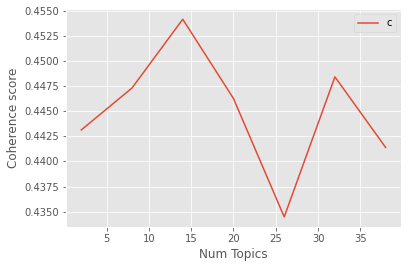

In [70]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [71]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4431
Num Topics = 8  has Coherence Value of 0.4473
Num Topics = 14  has Coherence Value of 0.4542
Num Topics = 20  has Coherence Value of 0.4463
Num Topics = 26  has Coherence Value of 0.4345
Num Topics = 32  has Coherence Value of 0.4484
Num Topics = 38  has Coherence Value of 0.4414


In [73]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(22, '0.086*"trim" + 0.035*"kshv" + 0.031*"specific" + 0.030*"pmo" + 0.015*"isoform" + 0.014*"lytic" + 0.014*"conjugate" + 0.013*"family" + 0.013*"highly" + 0.013*"domain"'), (25, '0.054*"orphanage" + 0.029*"outbreak" + 0.024*"infant" + 0.023*"cause" + 0.021*"purkinje" + 0.020*"lung" + 0.015*"month" + 0.015*"feature" + 0.014*"finding" + 0.013*"severe"'), (33, '0.049*"line" + 0.031*"great" + 0.029*"lrfi" + 0.025*"hrfi" + 0.019*"birth" + 0.018*"endotoxin" + 0.015*"pregnancy" + 0.015*"phase" + 0.014*"different" + 0.012*"less"'), (4, '0.047*"active" + 0.043*"free" + 0.040*"mean" + 0.040*"source" + 0.037*"use" + 0.036*"long" + 0.034*"database" + 0.033*"grant" + 0.033*"form" + 0.032*"reinfection"'), (27, '0.045*"life" + 0.031*"asthma" + 0.024*"serum" + 0.024*"right" + 0.015*"invasive_aspergillosis" + 0.014*"condition" + 0.014*"excess" + 0.014*"may" + 0.013*"skin" + 0.013*"chronic"'), (9, '0.021*"use" + 0.017*"dove" + 0.017*"bird" + 0.013*"concern" + 0.012*"nurse" + 0.012*"influenza" + 0.012

In [74]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
26    -0.046335 -0.139211       1        1  8.002321
6      0.018634 -0.208894       2        1  7.053402
3      0.023729 -0.190601       3        1  6.402431
24     0.111117 -0.126445       4        1  6.289043
0      0.197947  0.115209       5        1  5.607562
28     0.115275 -0.032049       6        1  5.200916
12    -0.016768 -0.112015       7        1  4.136275
19     0.126068  0.134961       8        1  4.045376
16     0.123367  0.145153       9        1  4.010234
10     0.082644 -0.154742      10        1  3.850179
5      0.107381 -0.006458      11        1  3.703282
11     0.171866  0.132503      12        1  3.452264
7      0.047740 -0.128791      13        1  3.403248
18     0.146465  0.047268      14        1  3.147443
34     0.038262 -0.113400      15        1  3.100194
1      0.131668  0.053603      16        1  2.935670
17     0.091385  0.053042      17        1  2.688757
23     0.082159  0.026660      18        1  2.541008
20    -0.026820 -0.023875      19        1  2.520893
30     0.088192  0.018173      20        1  2.370342
21    -0.052469 -0.110486      21        1  1.966277
15     0.007198  0.137321      22        1  1.779399
29     0.029954  0.146716      23        1  1.491267
32    -0.059927  0.007726      24        1  1.375942
14    -0.104212  0.002505      25        1  1.281829
31    -0.045124 -0.016751      26        1  1.108928
13    -0.036036 -0.068950      27        1  1.105552
2     -0.098831 -0.018952      28        1  1.042374
8     -0.134412 -0.079301      29        1  0.929712
9     -0.185379 -0.071248      30        1  0.861145
25    -0.215191  0.050679      31        1  0.648476
27    -0.223223  0.117677      32        1  0.548231
4     -0.214585  0.143017      33        1  0.540476
33    -0.195190  0.093607      34        1  0.495742
22    -0.086547  0.176350      35        1  0.363807, topic_info=           Term          Freq         Total Category  logprob  loglift
198       virus  39818.000000  39818.000000  Default  30.0000  30.0000
285        cell  26305.000000  26305.000000  Default  29.0000  29.0000
37      protein  22183.000000  22183.000000  Default  28.0000  28.0000
272     patient  16664.000000  16664.000000  Default  27.0000  27.0000
843     vaccine  10021.000000  10021.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
2675       loss     76.727119   1011.405151  Topic35  -4.9089   3.0375
2628     member     74.997536   1081.627563  Topic35  -4.9317   2.9475
63    associate     76.663429   5073.472656  Topic35  -4.9097   1.4239
32      peptide     73.145187   2784.765137  Topic35  -4.9567   1.9768
235        play     71.467339   2678.657959  Topic35  -4.9799   1.9925

[2440 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
708        1  0.002751   ability
708        2  0.055569   ability
708        3  0.001651   ability
708        4  0.101235   ability
708        5  0.070425   ability
...      ...       ...       ...
2065      26  0.042878     yield
27841     29  0.975805       yrs
2514      15  0.993267  zoonosis
707       15  0.998474  zoonotic
13784     28  0.993389     étude

[9393 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[27, 7, 4, 25, 1, 29, 13, 20, 17, 11, 6, 12, 8, 19, 35, 2, 18, 24, 21, 31, 22, 16, 30, 33, 15, 32, 14, 3, 9, 10, 26, 28, 5, 34, 23])

In [99]:
import operator

def element_1(x):
    return x[1]

def format_topics_sentences(ldamodel=lda_model_new, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=element_1, reverse=True)
        #row = max(gs_clf.grid_scores_, key=lambda x: x[1])       
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

TypeError: ignored

In [0]:
lda_model_new = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [98]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('basis', 1),
  ('better', 1),
  ('bind', 2),
  ('binding', 1),
  ('characterise', 1),
  ('class', 1),
  ('close', 1),
  ('conservation', 1),
  ('counterpart', 1),
  ('current', 1),
  ('define', 1),
  ('determine', 1),
  ('establish', 1),
  ('exogenous', 1),
  ('family', 2),
  ('fold', 1),
  ('form', 2),
  ('function', 1),
  ('high', 1),
  ('identify', 1),
  ('ill', 1),
  ('impact', 1),
  ('involve', 1),
  ('juxtaposition', 1),
  ('level', 1),
  ('levl', 1),
  ('many', 1),
  ('may', 1),
  ('molecular', 1),
  ('monomer', 1),
  ('non', 1),
  ('originate', 1),
  ('peptide', 3),
  ('perspective', 1),
  ('produce', 1),
  ('production', 1),
  ('protease', 1),
  ('protein', 4),
  ('relative', 1),
  ('remain', 1),
  ('reveal', 1),
  ('rhinoviral', 1),
  ('seek', 1),
  ('sequence', 2),
  ('site', 2),
  ('solve', 1),
  ('structural', 2),
  ('structure', 2),
  ('study', 1),
  ('subsequently', 1),
  ('suggest', 1),
  ('think', 2),
  ('together', 1),
  ('understanding', 1),
  ('unexpectedly', 1),